In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

Populating the interactive namespace from numpy and matplotlib


/home/miguel/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

# Get the initial states
root = isolation.isolation.Isolation()
opening_states = list(b.get_full_states(root, depth=full_search_depth))

# Generate the matches
matches = [(agents, state, time_limit, match_id) 
           for match_id, state in enumerate(opening_states)]
matches = matches * 3
print('Generated {} matches.'.format(len(matches)))

Generated 29403 matches.


In [3]:
num_processes = 4
batch_size = 100
batch_num_file = 'batch_num.txt'

# Small test for debugging
# matches = matches[:100]

# Create or load the book
book = b.load_latest_book(depth=depth)

# Make some batches to save the results once in a while
x = matches
batches = [x[i*batch_size:(i+1)*batch_size] 
           for i in range(len(x) // batch_size + (len(x) % batch_size != 0))]

# Get only the unprocessed batches
if os.path.exists(batch_num_file):
    with open(batch_num_file, 'r') as file:
        last_batch = int(file.read())
else:
    last_batch = -1

# Now fill the book!
pool = Pool(num_processes)

for batch_num in range(last_batch + 1, len(batches)):
    tic = time.time()
    batch = batches[batch_num]
    print('Processing batch {} of {}'.format(batch_num, len(batches)))
    for result in pool.imap_unordered(isolation.play, batch):
        winner, game_history, match_id = result
        # print('Results for match {}: {} wins.'.format(match_id, winner.name))
        _, state, _, _ = matches[match_id]
        if state.locs[1] is not None:
            game_history.insert(0,state.locs[1])
        if state.locs[0] is not None:
            game_history.insert(0,state.locs[0])
        root = isolation.isolation.Isolation()
        b.process_game_history(root,
                               game_history, 
                               book,
                               agent_names.index(winner.name),
                               active_player=state.ply_count % 2,
                               depth=depth)
    toc = time.time()
    print('Batch time {} seconds.'.format((toc-tic)))
    b.save_book(book)
    with open(batch_num_file, 'w') as file:
        file.write(str(batch_num))
    b.remove_old_books()

Processing batch 243 of 295
Batch time 278.6398425102234 seconds.
Saving: book2018-06-20_07S32S15.097174.pkl
rm book2018-06-19_23S29S48.284381.pkl
Processing batch 244 of 295
Batch time 273.47703528404236 seconds.
Saving: book2018-06-20_07S36S49.254472.pkl
rm book2018-06-20_07S32S15.097174.pkl
Processing batch 245 of 295
Batch time 274.8106195926666 seconds.
Saving: book2018-06-20_07S41S24.666917.pkl
rm book2018-06-20_07S36S49.254472.pkl
Processing batch 246 of 295
Batch time 275.98363161087036 seconds.
Saving: book2018-06-20_07S46S01.283919.pkl
rm book2018-06-20_07S41S24.666917.pkl
Processing batch 247 of 295
Batch time 267.88091468811035 seconds.
Saving: book2018-06-20_07S50S29.772492.pkl
rm book2018-06-20_07S46S01.283919.pkl
Processing batch 248 of 295
Batch time 274.3075478076935 seconds.
Saving: book2018-06-20_07S55S04.645943.pkl
rm book2018-06-20_07S50S29.772492.pkl
Processing batch 249 of 295
Batch time 269.51369881629944 seconds.
Saving: book2018-06-20_07S59S34.753640.pkl
rm bo

In [4]:
sum(abs(value[0]) for value in book.values())

131645

In [5]:
sum(abs(value[1]) for value in book.values())

382239

In [6]:
29403*34 / (10*3600)  # Estimated time in hours

27.7695

In [7]:
import pandas as pd

v = pd.Series([v[0] for v in book.values()])

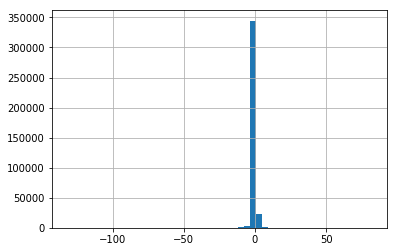

In [8]:
v.hist(bins=50)

In [9]:
v.describe()

count    374097.000000
mean         -0.000345
std           1.359358
min        -132.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          82.000000
dtype: float64

In [10]:
v.min()

-132

In [11]:
worst = min(((k, v) for k, v in book.items()), key=lambda x: x[1][0])
worst[0]

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 57)

In [12]:
from isolation.isolation import Isolation
state = Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))

print(isolation.DebugState.from_state(state.result(57)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



What about the other symmetrical ones

In [13]:
s1 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 56)
s2 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 58)
s3 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 70)
s4 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 44)

In [14]:
book[s1]

[-54, 1186]

In [15]:
book[s2]

[-54, 1186]

In [16]:
book[s3]

[82, 1190]

In [17]:
book[s4]

[82, 1190]

### I think I have ply_count=1,2,3,4 in the book but not ply_count=0

In [18]:
len(book.items())

374097

### Idea: show a heat matrix for the initial move

In [19]:
first = {item:value[0] for item, value in book.items() if item[0].ply_count==0}

In [20]:
len(first)

99

In [21]:
first

{(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  0): 37,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  1): 2,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  2): -56,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  3): -19,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  4): -13,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  5): 32,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  6): -13,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  7): -19,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  8): -56,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  9): 2,
 (Isolation(boar

In [22]:
pos_value = {key[1]:value for key,value in first.items()}
pos_value

{0: 37,
 1: 2,
 2: -56,
 3: -19,
 4: -13,
 5: 32,
 6: -13,
 7: -19,
 8: -56,
 9: 2,
 10: 37,
 13: -1,
 14: 62,
 15: 9,
 16: 17,
 17: -17,
 18: 42,
 19: -17,
 20: 17,
 21: 9,
 22: 62,
 23: -1,
 26: 23,
 27: -23,
 28: 12,
 29: 59,
 30: -85,
 31: -52,
 32: -85,
 33: 59,
 34: 12,
 35: -23,
 36: 23,
 39: -39,
 40: 30,
 41: 39,
 42: 20,
 43: -14,
 44: 82,
 45: -14,
 46: 20,
 47: 39,
 48: 30,
 49: -39,
 52: -98,
 53: 6,
 54: 30,
 55: -94,
 56: -54,
 57: -132,
 58: -54,
 59: -94,
 60: 30,
 61: 6,
 62: -98,
 65: -39,
 66: 30,
 67: 39,
 68: 20,
 69: -14,
 70: 82,
 71: -14,
 72: 20,
 73: 39,
 74: 30,
 75: -39,
 78: 23,
 79: -23,
 80: 12,
 81: 59,
 82: -85,
 83: -52,
 84: -85,
 85: 59,
 86: 12,
 87: -23,
 88: 23,
 91: -1,
 92: 62,
 93: 9,
 94: 17,
 95: -17,
 96: 42,
 97: -17,
 98: 17,
 99: 9,
 100: 62,
 101: -1,
 104: 37,
 105: 2,
 106: -56,
 107: -19,
 108: -13,
 109: 32,
 110: -13,
 111: -19,
 112: -56,
 113: 2,
 114: 37}

In [23]:
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
filled_vals

{0: 37,
 1: 2,
 2: -56,
 3: -19,
 4: -13,
 5: 32,
 6: -13,
 7: -19,
 8: -56,
 9: 2,
 10: 37,
 11: 0,
 12: 0,
 13: -1,
 14: 62,
 15: 9,
 16: 17,
 17: -17,
 18: 42,
 19: -17,
 20: 17,
 21: 9,
 22: 62,
 23: -1,
 24: 0,
 25: 0,
 26: 23,
 27: -23,
 28: 12,
 29: 59,
 30: -85,
 31: -52,
 32: -85,
 33: 59,
 34: 12,
 35: -23,
 36: 23,
 37: 0,
 38: 0,
 39: -39,
 40: 30,
 41: 39,
 42: 20,
 43: -14,
 44: 82,
 45: -14,
 46: 20,
 47: 39,
 48: 30,
 49: -39,
 50: 0,
 51: 0,
 52: -98,
 53: 6,
 54: 30,
 55: -94,
 56: -54,
 57: -132,
 58: -54,
 59: -94,
 60: 30,
 61: 6,
 62: -98,
 63: 0,
 64: 0,
 65: -39,
 66: 30,
 67: 39,
 68: 20,
 69: -14,
 70: 82,
 71: -14,
 72: 20,
 73: 39,
 74: 30,
 75: -39,
 76: 0,
 77: 0,
 78: 23,
 79: -23,
 80: 12,
 81: 59,
 82: -85,
 83: -52,
 84: -85,
 85: 59,
 86: 12,
 87: -23,
 88: 23,
 89: 0,
 90: 0,
 91: -1,
 92: 62,
 93: 9,
 94: 17,
 95: -17,
 96: 42,
 97: -17,
 98: 17,
 99: 9,
 100: 62,
 101: -1,
 102: 0,
 103: 0,
 104: 37,
 105: 2,
 106: -56,
 107: -19,
 108: -13,
 109: 

In [24]:
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]

In [25]:
rows

[[37, 2, -56, -19, -13, 32, -13, -19, -56, 2, 37, 0, 0],
 [-1, 62, 9, 17, -17, 42, -17, 17, 9, 62, -1, 0, 0],
 [23, -23, 12, 59, -85, -52, -85, 59, 12, -23, 23, 0, 0],
 [-39, 30, 39, 20, -14, 82, -14, 20, 39, 30, -39, 0, 0],
 [-98, 6, 30, -94, -54, -132, -54, -94, 30, 6, -98, 0, 0],
 [-39, 30, 39, 20, -14, 82, -14, 20, 39, 30, -39, 0, 0],
 [23, -23, 12, 59, -85, -52, -85, 59, 12, -23, 23, 0, 0],
 [-1, 62, 9, 17, -17, 42, -17, 17, 9, 62, -1, 0, 0],
 [37, 2, -56, -19, -13, 32, -13, -19, -56, 2, 37]]

In [26]:
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows

[[37, 2, -56, -19, -13, 32, -13, -19, -56, 2, 37],
 [-1, 62, 9, 17, -17, 42, -17, 17, 9, 62, -1],
 [23, -23, 12, 59, -85, -52, -85, 59, 12, -23, 23],
 [-39, 30, 39, 20, -14, 82, -14, 20, 39, 30, -39],
 [-98, 6, 30, -94, -54, -132, -54, -94, 30, 6, -98],
 [-39, 30, 39, 20, -14, 82, -14, 20, 39, 30, -39],
 [23, -23, 12, 59, -85, -52, -85, 59, 12, -23, 23],
 [-1, 62, 9, 17, -17, 42, -17, 17, 9, 62, -1],
 [37, 2, -56, -19, -13, 32, -13, -19, -56, 2, 37]]

In [27]:
rows = np.array(rows)
rows

array([[  37,    2,  -56,  -19,  -13,   32,  -13,  -19,  -56,    2,   37],
       [  -1,   62,    9,   17,  -17,   42,  -17,   17,    9,   62,   -1],
       [  23,  -23,   12,   59,  -85,  -52,  -85,   59,   12,  -23,   23],
       [ -39,   30,   39,   20,  -14,   82,  -14,   20,   39,   30,  -39],
       [ -98,    6,   30,  -94,  -54, -132,  -54,  -94,   30,    6,  -98],
       [ -39,   30,   39,   20,  -14,   82,  -14,   20,   39,   30,  -39],
       [  23,  -23,   12,   59,  -85,  -52,  -85,   59,   12,  -23,   23],
       [  -1,   62,    9,   17,  -17,   42,  -17,   17,    9,   62,   -1],
       [  37,    2,  -56,  -19,  -13,   32,  -13,  -19,  -56,    2,   37]])

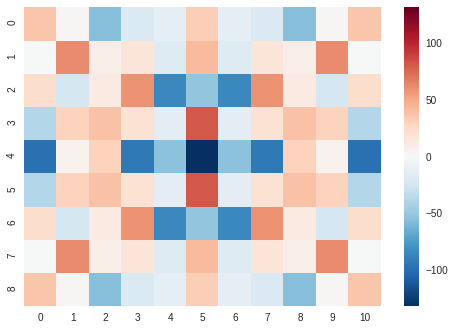

In [28]:
import seaborn as sns
sns.heatmap(rows)

In [29]:
second = {item:value[0] for item, value in book.items() if item[0].ply_count==1}

In [30]:
len(second)

9702

In [31]:
pd.Series(list(second.values())).describe()

count    9702.000000
mean        0.017728
std         5.311229
min       -15.000000
25%        -4.000000
50%         0.000000
75%         4.000000
max        13.000000
dtype: float64

In [32]:
third = {item:value[0] for item, value in book.items() if item[0].ply_count==2}

In [33]:
len(third)

55096

In [34]:
pd.Series(list(third.values())).describe()

count    55096.000000
mean        -0.003122
std          1.825351
min         -8.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          6.000000
dtype: float64

In [35]:
fourth = {item:value[0] for item, value in book.items() if item[0].ply_count==3}
len(fourth)

309200

In [36]:
pd.Series(list(fourth.values())).describe()

count    309200.000000
mean          0.000139
std           0.375715
min          -6.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
dtype: float64

In [37]:
sum(np.array(list(third.values())) != 0)

32520

In [38]:
sum(np.array(list(fourth.values())) != 0)

10189